# Project 1: Analyzing Spectroscopic data from OMM

In [129]:
import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
from astropy.utils.data import download_file
from scipy.stats import lognorm

plt.rcParams['figure.figsize'] = (12, 2)

## Part 1: Exploration

We can define a plotting function for our FITS files for repeated plotting down the line

In [35]:
#NOTE: Turn basic fits astropy file manipulations into a class
# class AstropyFits:
#     def __init__(self):
#         self.fits_file = fits_file
#
#     def convert_fits_to_data(self, ):


In [36]:
def plot_fits(data, vmin, vmax, title, norm = None):
    #plot the data...
    fig, ax = plt.subplots()
    im = ax.imshow(data, vmin=vmin, vmax=vmax, cmap='viridis', origin='lower', norm=norm, aspect='auto')
    ax.set_xlabel('x pixels')
    ax.set_ylabel('y pixels')
    ax.set_title(title)
    fig.colorbar(im)

def fits_to_data(file_name):
    source_file = fits.open(file_name)
    source_data = source_file[0].data
    return source_data, source_file


Let's produce some rough visualizations of the source file, a calibration lamp, and dark frame.

In [37]:
parent = './fit_files/'
bias = './bias/'
dark = './dark/'
flat = './flat/'
source_fits = parent + 'source.fits'
cal_lamp_fits = parent + 'calibration.fits'
bias_frame_fits = parent + bias + 'bias0008.fits'
dark_frame_fits = parent + dark + 'dark0001.fits'

In [38]:
s_data, s_file = fits_to_data(source_fits)
cal_lamp_data, cal_lamp_file = fits_to_data(cal_lamp_fits)
bias_frame_data, bias_frame_file = fits_to_data(bias_frame_fits)
dark_frame_data, dark_frame_file = fits_to_data(dark_frame_fits)

In [39]:
print((s_data.shape))

(512, 2720)


Viewing the header of the source file, we can see the source is Orion and look at other things like photometric results and observing details.

In [54]:
source_header = s_file[0].header
print(repr(source_header))

SIMPLE  =                    T  / Standard Fits                                 
BITPIX  =                   16  / Bits par pixel                                
NAXIS   =                    2  / Nombre de dimensions                          
NAXIS1  =                 2720  / Axe des X                                     
NAXIS2  =                  512  / Axe des Y                                     
BSCALE  =           1.000000E0  / REAL = TAPE*BSCALE + BZERO                    
BZERO   =           3.276800E4  /                                               
OBJECT  = 'orion   '           / Nom de l'objet                                 
OBSERVAT= 'omm     '           / Observatoire                                   
EXPTIME =              1800.00  / Temps d'exposition (sec)                      
DARKTIME=              1800.00  / Temps total ecoule (sec)                      
IMAGETYP= 'object  '           / Objet, Flat, Bias, etc.                        
DATE-OBS= '2019-10-27T08:21:

 [astropy.io.fits.verify]


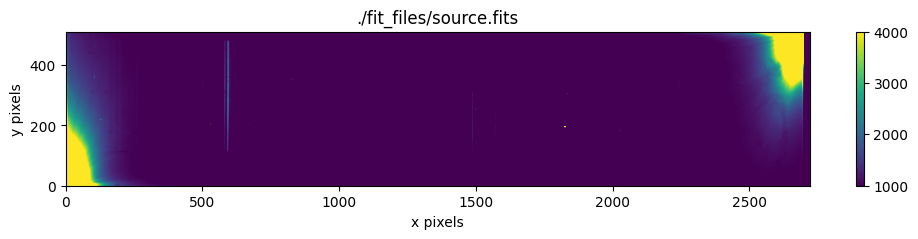

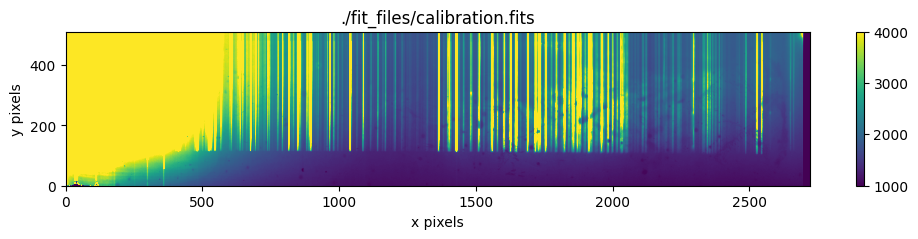

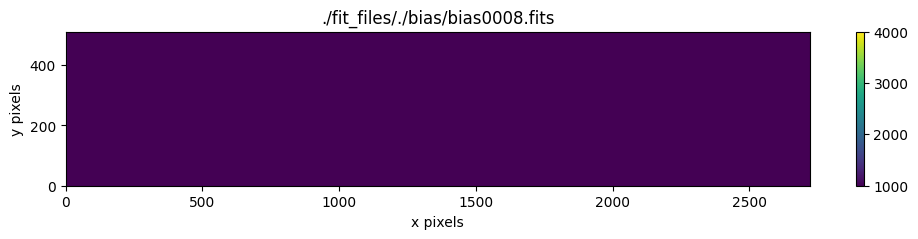

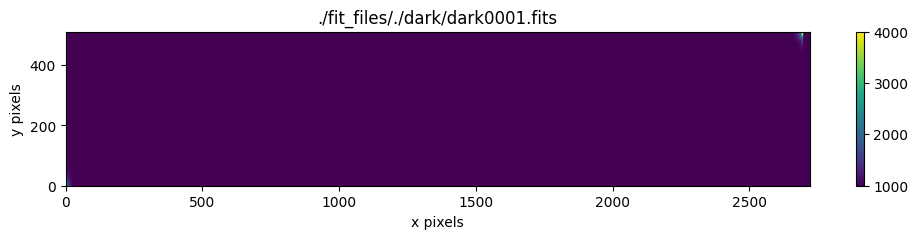

In [41]:
#Now let's plot the different images:
#we need to establish a minimum and maximum range to plot the intensity over
vmin = 1e3
vmax = 4e3

plot_fits(s_data, vmin, vmax, title=source_fits, norm=None)
plot_fits(cal_lamp_data, vmin, vmax, title=cal_lamp_fits, norm=None)
plot_fits(bias_frame_data, vmin, vmax, title=bias_frame_fits, norm=None)
plot_fits(dark_frame_data, vmin, vmax, title=dark_frame_fits, norm=None)


Let's take a look at what the 'data' files look like so we have an idea of what needs to be done algorithmically when trying to compute the PS.

In [42]:
print(type(s_data))
print(s_data)

<class 'numpy.ndarray'>
[[863 859   0 ... 848 852 856]
 [854 856   0 ... 856 847 844]
 [843 842   0 ... 838 847 841]
 ...
 [850 849   0 ... 846 849 841]
 [849 848   0 ... 849 839 850]
 [850 851   0 ... 855 841 847]]


Ok, so the data is just a 2D matrix and morever a Numpy array so we can perform all the basic math operations on it.

Text(0, 0.5, 'photon counts')

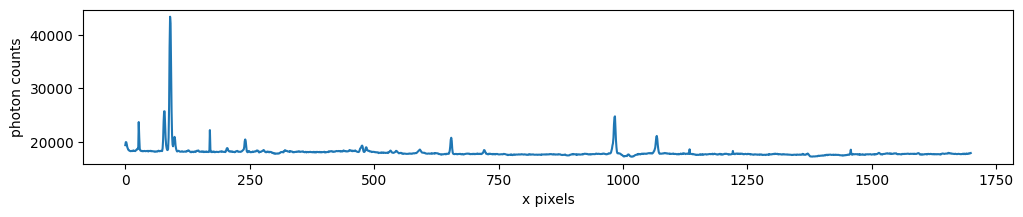

In [43]:
source_spectrum = np.sum(s_data[200:220, 500:2200], axis = 0)
# source_spectrum = np.sum(s_data[200:220], axis = 0)

plt.plot(source_spectrum)
plt.xlabel("x pixels")
plt.ylabel("photon counts")

## Part 2: Noise Removal

### Part 2.1 - Master bias

For the first part of the noise removal, we need to make a master bias frame. According to the project outline a ***bias*** frame is one where a minimum duration exposure was taken without significant light entering the detector. We should take a master bias frame by taking the median of all the bias frames included.

In [44]:
import os

directory = r"./fit_files/bias/"

bias_frames = []
for name in os.listdir(directory):
    flag = True
    if "Zone" in name:
        flag = False
    if flag:
        # print(name)
        bias_frames.append(name)

bias_data = []
bias_files = []
for fit_file in bias_frames:
    # print(fit_file)
    file_name = directory + fit_file
    # print(file_name)
    data, file = fits_to_data(directory + str(fit_file))
    bias_data.append(data)
    bias_files.append(file)

bias_array = np.zeros((bias_data[0].shape[0], bias_data[0].shape[1], len(bias_data)))
for num, data_file in enumerate(bias_data):
    bias_array[:, :, num] = data_file

median_bias = np.median(bias_array, axis = 2)
# print(median_bias)
# print(median_bias.shape)

Now that we've computed the median bias frame, let's plot it to try and see some of the qualitative features. Plotting first and then using the colorbar to select the a smaller range seems to show a bit more features at the side of the plot.

NOTE: Will need to answer in the write up what the bias frame is trying to correct for, as well as describe in qualitatively.

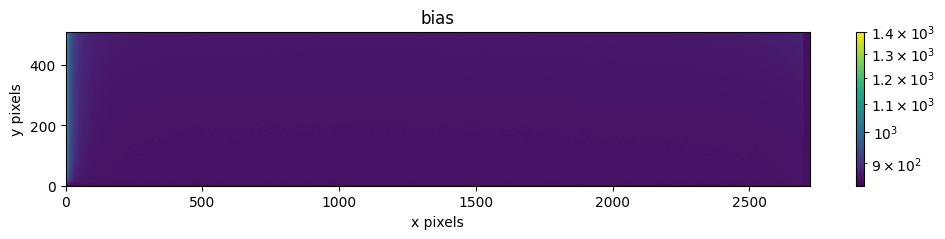

In [45]:
#define again some vmin and vmax
vmin = None
vmax = None
norm = "log"
# norm = None
plot_fits(median_bias, vmin=vmin, vmax=vmax, title="bias", norm=norm)

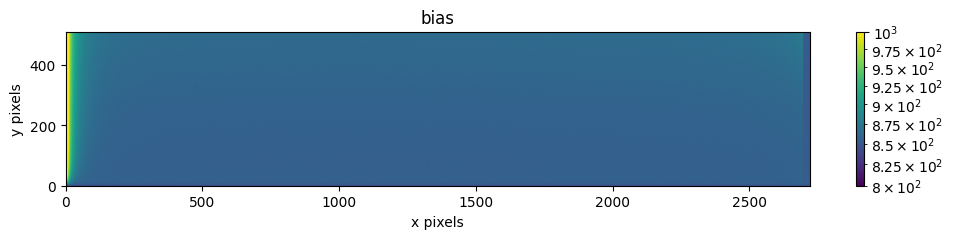

In [46]:
#define again some vmin and vmax
vmin = 800
vmax = 1000
norm = "log"
# norm = None
plot_fits(median_bias, vmin=vmin, vmax=vmax, title="bias", norm=norm)

Ok, now let's remove the bias from each of the dark, flats, calibration, and source_data, files.

In [47]:
#we have the source data file from befor it's just s_data. Unpacking the other files:
dir = r'./fit_files/dark/'
dark_frames = []
for name in os.listdir(dir):
    flag = True
    if "Zone" in name:
        flag = False
    if flag:
        dark_frames.append(name)
# print(dark_frames)

dark_data = []
dark_files = []
for file in dark_frames:
    file_name = dir + str(file)
    data, file = fits_to_data(file_name)
    dark_data.append(data)
    dark_files.append(file)


dir = r'./fit_files/flat/'
flat_frames = []
for name in os.listdir(dir):
    flag = True
    if "Zone" in name:
        flag = False
    if flag:
        flat_frames.append(name)
# print(dark_frames)

flat_data = []
flat_files = []
for file in flat_frames:
    file_name = dir + str(file)
    data, file = fits_to_data(file_name)
    flat_data.append(data)
    flat_files.append(file)

#Now let's subtract the bias from each of the dark and flat frames and both the
# srouce and calibration (arc) data
dark_bias = []
flat_bias = []
src_bias = 0
calibration_bias = 0

#Subtract median bias from each of the dark frames
for num, dark in enumerate(dark_data):
    # print(num)
    # print(dark_data[num])
    dark_data[num] = dark_data[num] - median_bias

#Subtract median bias from each of the flat frames
for num, flat in enumerate(flat_data):
    # print(num)
    # print(dark_data[num])
    flat_data[num] = flat_data[num] - median_bias

#From the source data
source_data = s_data - median_bias

#Read in the calibration data, since we didn't do this earlier on
calibration_data, calibration_file = fits_to_data('./fit_files/calibration.fits')

#Subtract median bias from the arc file
calibration_data = calibration_data - median_bias


When Matt is talking about the arc file, he must be talking about the calibration file (taken with the arc lamp) since the alternative (plotting the cuar.fits data file) is only useful for the spectrum

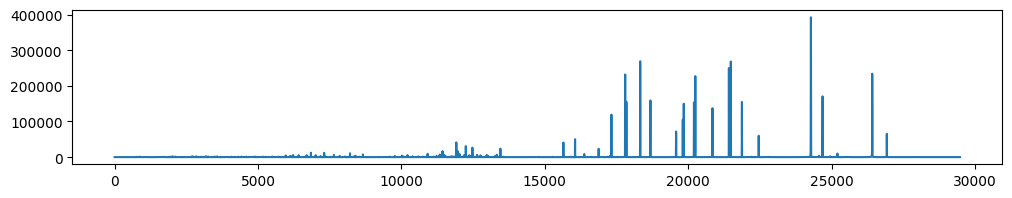

In [48]:
cuar_data, _ = fits_to_data('./fit_files/cuar.fits')
plt.plot(cuar_data)

#### Test plots for each of the flat, dark, source, and calibration files with median bias subtracted

### Part 2.2 - Master Dark

Our goal is to see which of the darks has the same exposure as the source, as this is the one we will want to subtract from the source file. Therefore, we print out the header of darks along with, again, the source file:

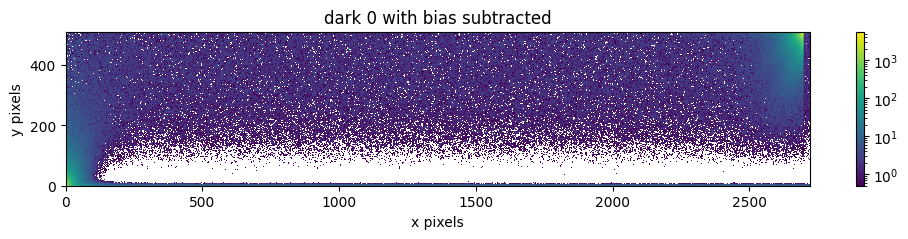

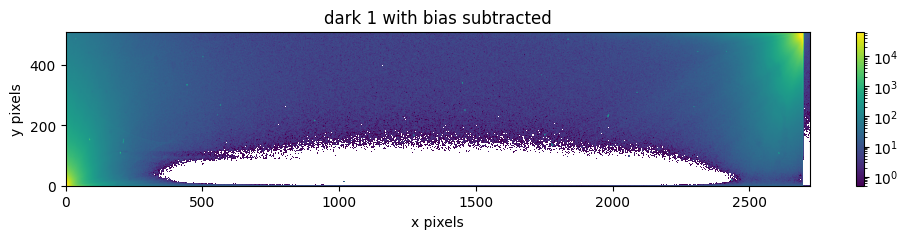

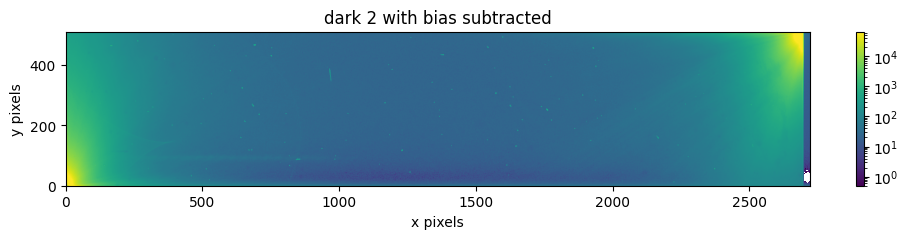

In [111]:
for i, dark_data_file in enumerate(dark_data):
    plot_fits(
        dark_data[i], vmin=None, vmax=None, title=f'dark {i} with bias subtracted', norm='log'
              )
#
# plot_fits(
#     dark_data[0], vmin=None, vmax=None, title='dark 3 with bias subtracted', norm='log'
#           )
# plot_fits(
#     dark_data[1], vmin=None, vmax=None, title='dark 3 with bias subtracted', norm='log'
#           )
# plot_fits(
#     dark_data[2], vmin=None, vmax=None, title='dark 3 with bias subtracted', norm='log'
#           )

In [65]:
#also display the headers since we care most about whichever one had the same exposure time as the source data
dark_data_header = dark_files[2][0].header
print(repr(dark_data_header))

SIMPLE  =                    T  / Standard Fits                                 
BITPIX  =                   16  / Bits par pixel                                
NAXIS   =                    2  / Nombre de dimensions                          
NAXIS1  =                 2720  / Axe des X                                     
NAXIS2  =                  512  / Axe des Y                                     
BSCALE  =           1.000000E0  / REAL = TAPE*BSCALE + BZERO                    
BZERO   =           3.276800E4  /                                               
OBJECT  = 'dark    '           / Nom de l'objet                                 
OBSERVAT= 'omm     '           / Observatoire                                   
EXPTIME =              1800.00  / Temps d'exposition (sec)                      
DARKTIME=              1800.00  / Temps total ecoule (sec)                      
IMAGETYP= 'dark    '           / Objet, Flat, Bias, etc.                        
DATE-OBS= '2019-10-27T10:18:

In [63]:
 #and compare with source file header to match exposure times
print(repr(source_header))

SIMPLE  =                    T  / Standard Fits                                 
BITPIX  =                   16  / Bits par pixel                                
NAXIS   =                    2  / Nombre de dimensions                          
NAXIS1  =                 2720  / Axe des X                                     
NAXIS2  =                  512  / Axe des Y                                     
BSCALE  =           1.000000E0  / REAL = TAPE*BSCALE + BZERO                    
BZERO   =           3.276800E4  /                                               
OBJECT  = 'orion   '           / Nom de l'objet                                 
OBSERVAT= 'omm     '           / Observatoire                                   
EXPTIME =              1800.00  / Temps d'exposition (sec)                      
DARKTIME=              1800.00  / Temps total ecoule (sec)                      
IMAGETYP= 'object  '           / Objet, Flat, Bias, etc.                        
DATE-OBS= '2019-10-27T08:21:

So, clearly dark 3 and the source have the same exposure time (it is 1800s). This is therefore the dark frame to use to dubtract from the data:

In [119]:
#subtracting the correct dark frame (number 3 ~ index num 2) from the source and calibration file
source_dark_adj = source_data - dark_data[2]
cal_dark_adj = calibration_data - dark_data[2]

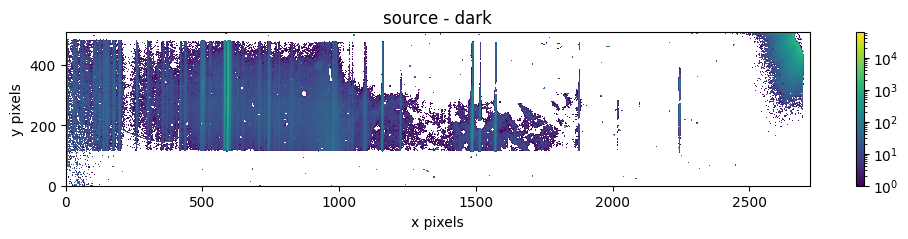

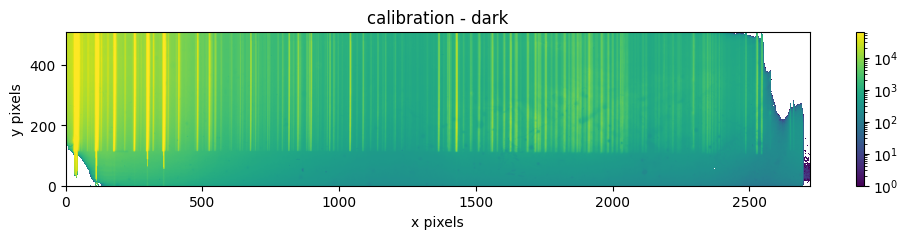

In [120]:
#and plot to to get a snapshot of how we're doing so far
plot_fits(
    source_dark_adj, vmin=None, vmax=None, title='source - dark', norm='log'
          )
plot_fits(
    cal_dark_adj, vmin=None, vmax=None, title='calibration - dark', norm='log'
          )

### Part 2.3 - Master Flat



A few of the flats

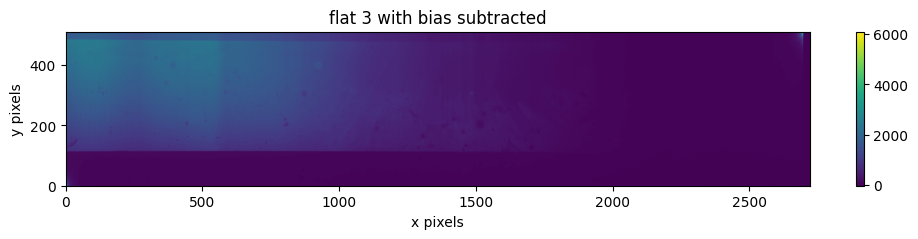

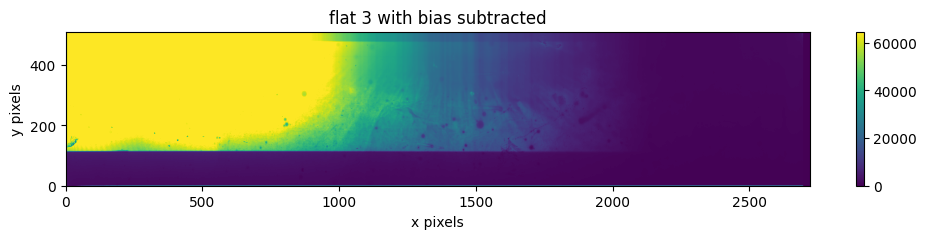

In [82]:
vmin=None
vmax=None
norm=None

#uncomment if want to plot all of the flats with bias subtracted
# for i, flat in enumerate(flat_data):
#     plot_fits(
#         flat, vmin=None, vmax=None, title=f'flat {i} with bias subtracted', norm=norm
#               )

#One example of good and too much saturation respectively
plot_fits(
    flat_data[3], vmin=None, vmax=None, title='flat 3 with bias subtracted', norm=norm
          )
plot_fits(
    flat_data[15], vmin=None, vmax=None, title='flat 3 with bias subtracted', norm=norm
          )


(23, 512, 2720)
(512, 2720)


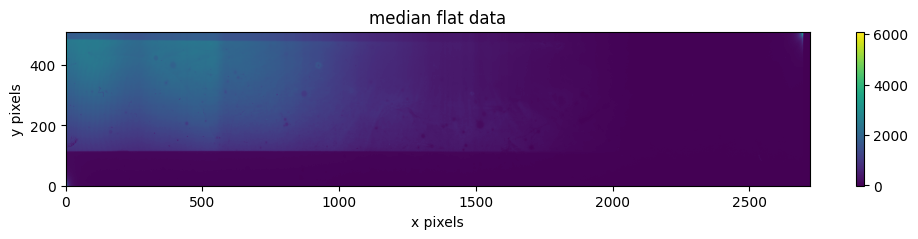

In [101]:
#indices of flats without significant saturation:
usable_flats_idxs = np.array([0, 2, 3, 5, 9, 10, 11, 12, 16, 19, 20, 21])

#Now get the median of the usable flats
flat_data = np.array(flat_data)
print(flat_data.shape)
print(np.median(flat_data, axis = 0).shape)
median_flat_data = np.median(flat_data, axis = 0)

#make a quick plot to again see what we're dealing with
plot_fits(
    median_flat_data, vmin=None, vmax=None, title='median flat data', norm=None
          )

/tmp/ipykernel_26876/2362845397.py:3: RuntimeWarning: divide by zero encountered in divide
  source_darkflat_adj = (source_dark_adj)/(median_flat_data)
/tmp/ipykernel_26876/2362845397.py:3: RuntimeWarning: invalid value encountered in divide
  source_darkflat_adj = (source_dark_adj)/(median_flat_data)
/tmp/ipykernel_26876/2362845397.py:4: RuntimeWarning: divide by zero encountered in divide
  cal_darkflat_adj = (cal_dark_adj)/(median_flat_data)
/tmp/ipykernel_26876/2362845397.py:4: RuntimeWarning: invalid value encountered in divide
  cal_darkflat_adj = (cal_dark_adj)/(median_flat_data)


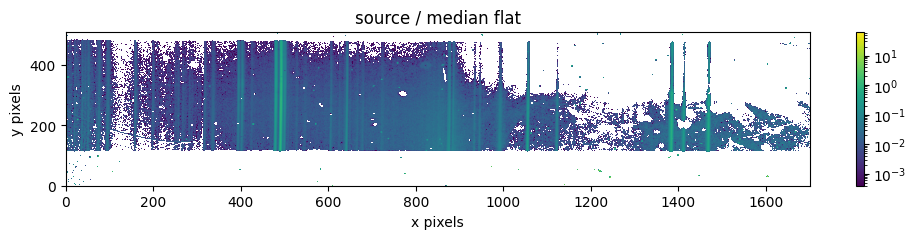

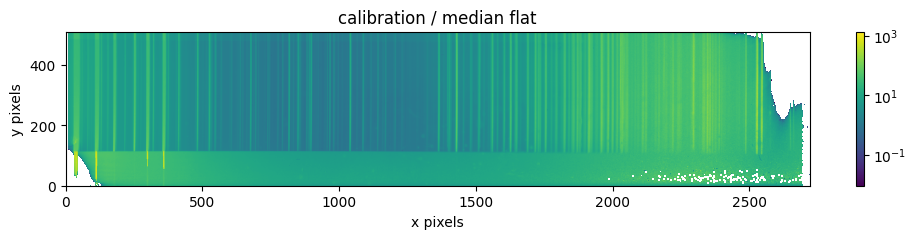

In [180]:
#adjusting for (dividing by) the flat data:
eps = 1e-5
source_darkflat_adj = (source_dark_adj)/(median_flat_data)
cal_darkflat_adj = (cal_dark_adj)/(median_flat_data)
# norm = SymLogNorm(linthresh=0.03)
norm = 'log'
# norm = None

plot_fits(
    source_darkflat_adj[:, 100:1800], vmin=None, vmax=None, title='source / median flat', norm=norm
          )
plot_fits(
    cal_darkflat_adj, vmin=None, vmax=None, title='calibration / median flat', norm=norm
          )

## Part 3. Wavelength calibration

### Part 3.1 2D to 1D arc spectrum

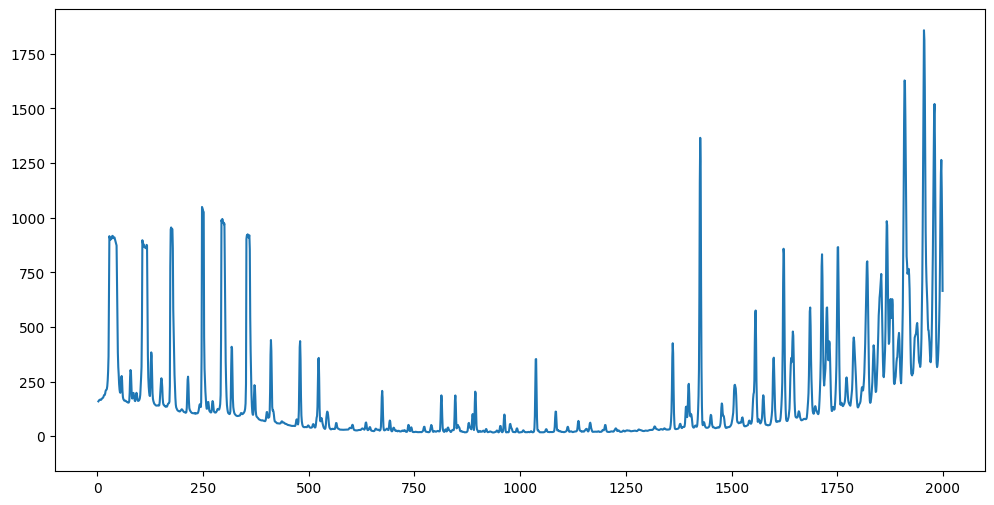

In [192]:
# cleaned_source_spectrum = np.sum(source_darkflat_adj[200:220, 100:1800], axis = 0)
plt.rcParams['figure.figsize'] = (12, 6)
cleaned_cal_spectrum = np.sum(cal_darkflat_adj[200:220, 0:2000], axis=0)

# print(cleaned_cal_spectrum.shape)
# plt.plot(cleaned_source_spectrum)
# plt.show()
plt.plot(cleaned_cal_spectrum)

### Part 3.2 Identifying lines using the cuar file

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    1 / Number of axes                                 
NAXIS1  =                29480 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2004-09-03T22:14:15' / Date FITS file was generated                  
IRAF-TLM= '15:14:15 (03/09/2004)' / Time of last modification                   
OBJECT  = '3250A   '           / Name of the object observed                    
OBSERVAT= 'KPNO              '  /  observatory                                  
OBSERVER= 'Willmarth         '  /  observers                                    
PROPID  = 'T&E               '  /  observing proposal ID                        
EXPTIME =             100.14

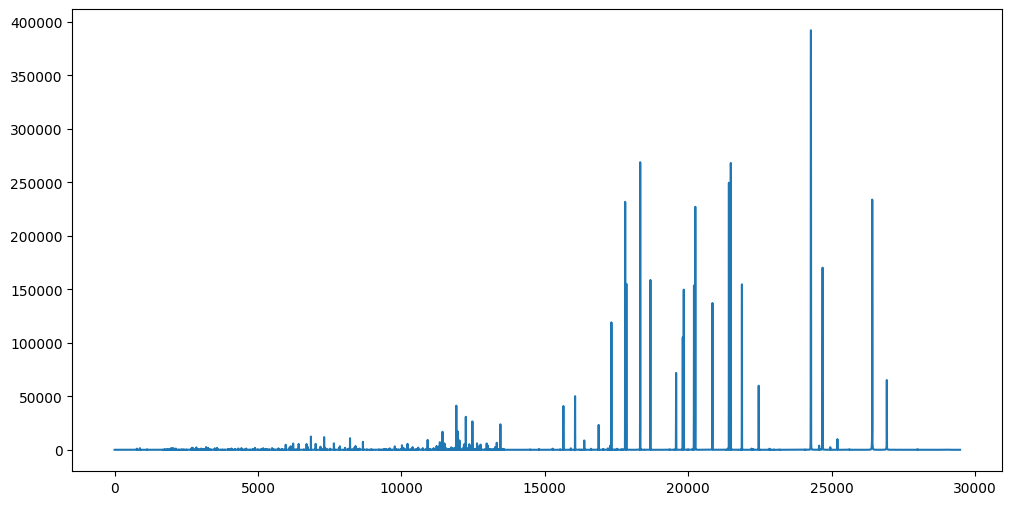

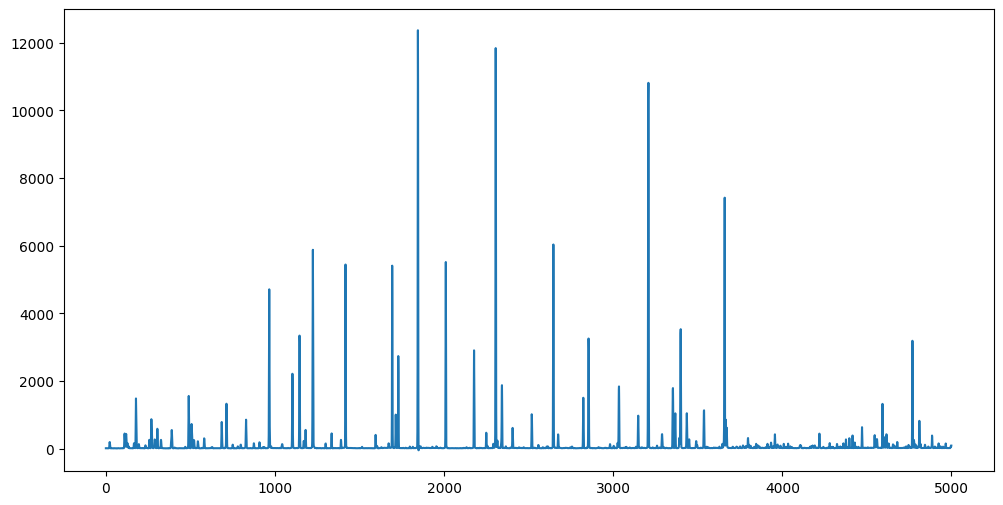

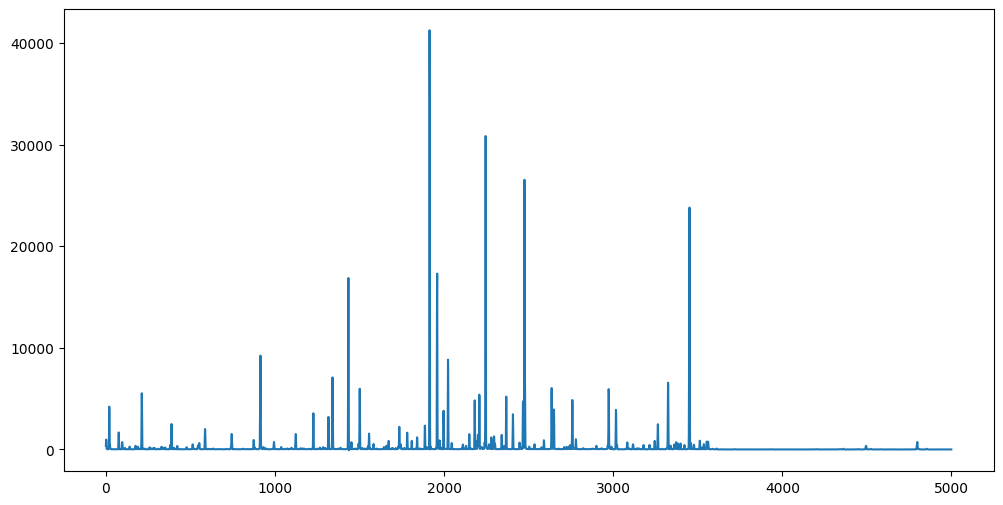

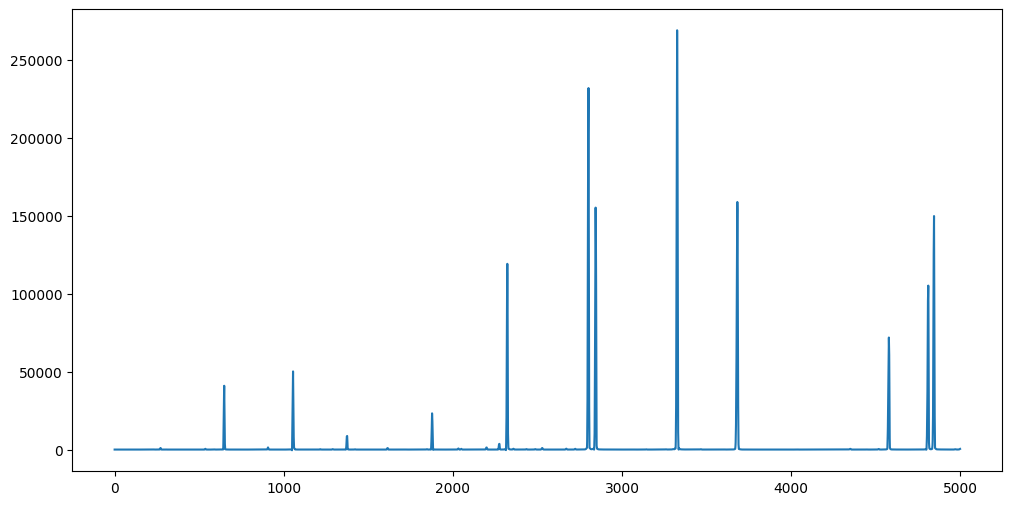

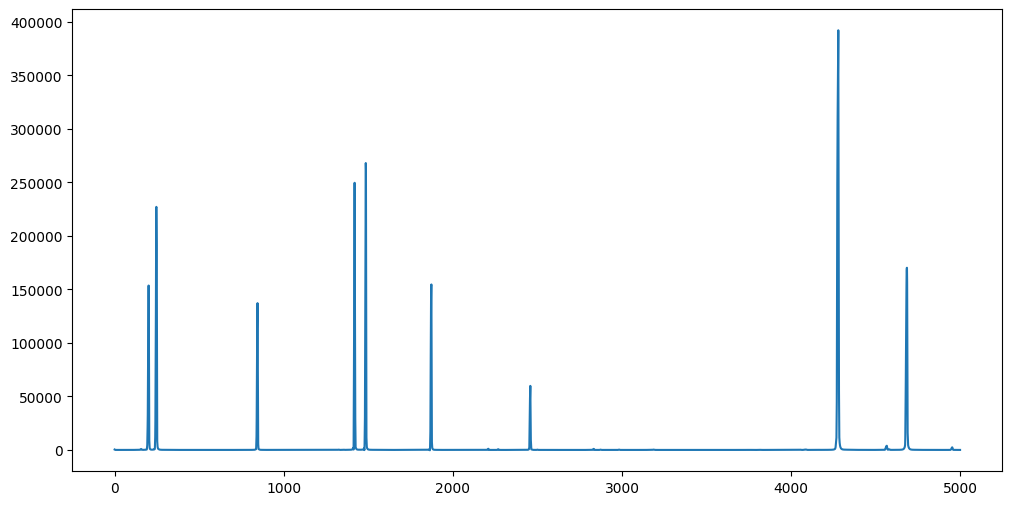

In [193]:
cuar_file_path = './fit_files/cuar.fits'
cuar_data, cuar_file = fits_to_data(cuar_file_path)
print(repr(cuar_file[0].header))
plt.plot(cuar_data)
plt.show()
plt.plot(cuar_data[5000:10000])
plt.show()
plt.plot(cuar_data[10000:15000])
plt.show()
plt.plot(cuar_data[15000:20000])
plt.show()
plt.plot(cuar_data[20000:25000])
